# EE 538: Analog Circuits for Sensor Systems
## Autumn 2020
## Instructor: Jason Silver

## Announcements

 - Solution to Assignment 1 posted on JupyterHub
 - Assignment 2 due Sunday, October 18 at midnight
    - Jupyter Notebook (.ipyb) submission on Canvas
    - For LTspice problems, include image (e.g. screen capture) of schematic(s)

## Week 3

 - Art of Electronics (AoE) Chapters 3, 4
 - Microelectronics (Sedra/Smith) Chapter 5, 6

## Overview

 - Last time...
     - BJT physics
     - Ebers Moll BJT model
     - Small-signal BJT model
     - Common-emitter amplifier
 - Today...
    - Common-emitter amplifier, cont.
    - Emitter-follower
    - Field-effect transistor
    - Small-signal FET model
    - FET-based circuits

## Words of wisdom

“A good understanding of transistors is very important, even if most of your circuits are made from ICs, because you need to understand the input and output properties of the IC in order to connect it to the rest of your circuit and to the outside world.”

– from The Art of Electronics 


## Python packages/modules

In [4]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
#%matplotlib notebook

def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b');
    ax.grid();
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    
def plot_xy2(x1, y1, x1label, y1label, x2, y2, x2label, y2label):
    fig, ax = plt.subplots(2, figsize = (10.0, 7.5));
    ax[0].plot(x1, y1, 'b');
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].plot(x2, y2, 'b');
    ax[1].set_xlabel(x1label)
    ax[1].set_xlabel(x2label);
    ax[1].set_ylabel(y2label);
    ax[1].grid();
    
    fig.align_ylabels(ax[:])
    
def plot_xlogy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogy(x, y, 'b');
    ax.grid();
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    
def read_ltspice_ac(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        z = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            complex = p[1].split(",")
            y.append(float(complex[0]))
            z.append(float(complex[1]))

    return x, y, z

def plot_logxy2(x1, y1, x2, y2, x1label, y1label, x2label, y2label):
    fig, ax = plt.subplots(2, figsize = (8.0, 6.0));
    ax[0].semilogx(x1, y1, 'b');
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].semilogx(x2, y2, 'b');
    ax[1].set_xlabel(x1label)
    ax[1].set_xlabel(x2label);
    ax[1].set_ylabel(y2label);
    ax[1].grid();
    
    fig.align_ylabels(ax[:])

## Common-emitter, revisited

<center><img src="img/CE_small_signal_full.png" width=800 /></center>

 - In the small-signal model, $V_{CC}$ (and any other DC voltage) becomes a "virtual" or "AC" ground
 - $r_o$ appears in parallel with $R_C$, resulting in a slightly modified expression for the gain:
 
\begin{align}
v_{out} = -g_mv_{in} \cdot r_o||R_C \rightarrow A_v = \dfrac{v_{out}}{v_{in}} = -g_m \cdot r_o||R_C
\end{align}
 - However, $r_o$ is typically much larger than $R_C$, allowing the common approximation
 
\begin{align}
A_v = \dfrac{v_{out}}{v_{in}} \approx -g_m \cdot R_C 
\end{align}
 

## Load capacitance

<center><img src="img/CE_small_signal_AC.png" width=800 /></center>

 - $C_L$ represents either an explicit capacitor or device capacitance of the following stage
 - The resulting small-signal transfer function is given by
 
 $$\dfrac{v_{out}}{v_{in}}(s) = -g_m\cdot\left(R_C||r_o||Z_{CL}\right) $$
 
 - In this case, the transfer function can be easily separated into DC and AC components. Let $R_{eq} = R_C||r_o$:
 
  $$\dfrac{v_{out}}{v_{in}}(s) = -g_m \cdot R_{eq}\cdot\dfrac{1}{1+sC_LR_{eq}} $$

## Common-emitter frequency response

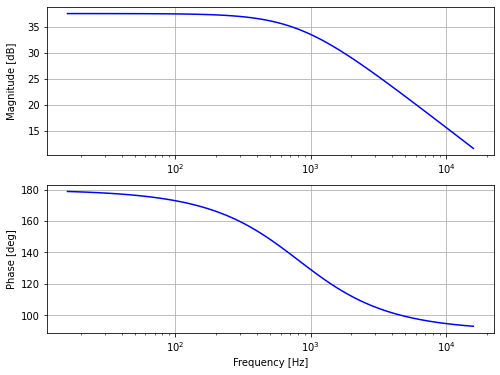

In [5]:
# DC operating point
I_C0 = 1e-3
V_T = 26e-3
V_A = 100

# small-signal parameters
g_m = I_C0/V_T
r_o = V_A/I_C0 

# design values
R_C = 2e3
C_L = 100e-9
R_eq = R_C*r_o/(R_C+r_o)

gain_ac = signal.TransferFunction([-g_m*R_eq], [R_eq*C_L, 1])
w, mag, phase = gain_ac.bode()       
f = w/2/np.pi        
plot_logxy2(f, mag, f, phase, 'Frequency [Hz]', 'Magnitude [dB]',
           'Frequency [Hz]', 'Phase [deg]')

## Temperature dependence

 - Analog circuits must be designed to function over a wide range of temperatures to ensure robustness
 - Some example temperature ranges:
     - Commercial temperature range: $0^{\circ}C$ to $60^{\circ}C$
     - Industrial temperature range: $-40^{\circ}C$ to $85^{\circ}C$
     - Military temperature range: $-40^{\circ}C$ to $125^{\circ}C$ 
 - Both $I_S$ and $V_T$ exhibit temperature dependence, resulting in different values of $I_C$, $g_m$, and voltage gain at different temperatures:
 $$ A_v = -g_m\cdot R_C = \dfrac{1}{V_T}I_S(T)e^{\frac{V_{BE}}{V_T}}R_C$$
 
 - This will be a problem it prevents our circuit from meeting specifications over the target temperature range
 - Let's take a look at a SPICE simulation of gain versus temperature for a common-emitter amplifier
 

## Common-emitter gain versus temperature

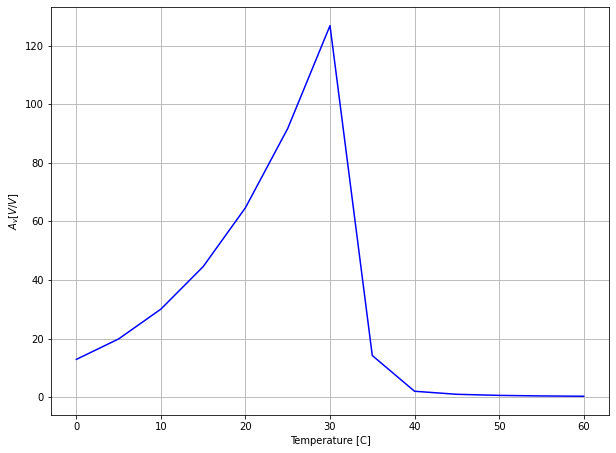

In [6]:
temp, reals, imags = read_ltspice_ac('Av_vs_temp.csv')
gain = np.sqrt(np.asarray(reals)**2 + np.asarray(imags)**2)
plot_xy(temp, gain, 'Temperature [C]','$A_v [V/V]$')

 - What a disaster! Even over the commercial temperature range, our voltage gain varies by several orders of magnitude, and the circuit becomes unusable (i.e. it does not provide gain) at high temperatures
 - How can we ensure a more robust design?

## Addition of bias resistor R<sub>E</sub>

<center><img src="img/CE_emitter_bias.png" width=400 /></center>

 - If we make the assumption that $V_{BE}$ is constant (say, $600 mV$), we can set the base voltage $V_{B0}$ to produce a collector current that is approximately constant:
 
$$ I_{C0} = \dfrac{V_{E0}}{R_E} \approx \dfrac{V_{B0} - 0.6V}{R_E} $$
 
 - $V_{BE0}$ acts as a "battery," while $R_E$ is used as a current source in conjuction with the resulting emitter voltage $V_{E0}$
 - We determine the bias voltage $V_{B0}$ as
 
 $$ V_{B0} = I_{C0} \cdot R_E + 0.6V $$



## Effect of R<sub>E</sub> on gain

<center><img src="img/CE_degen_small_signal_qualitative.png" width=500 /></center>

$$ v_e \approx v_{in} $$

$$ i_c \approx \dfrac{v_{in}}{R_E}$$

$$ v_{out} \approx -R_C\cdot \dfrac{v_{in}}{R_E} $$

<br>

 - $R_E$ acts to stabilize the emitter voltage $v_e$
 
 - As $v_{in}$ begins to increase, the current through $R_E$, and thus the voltage $v_e$, also starts increasing
 
 - However, the increase in $v_e$ results in a decrease in $v_{be}$, which counteracts the increase in $v_{in}$
 - This is a form of negative feedback, which causes $v_e$ to "follow" $v_{in}$
 - The result is a weaker dependence of the gain on the *temperature-dependent* value of $g_m$

## Small-signal voltage gain

<center><img src="img/CE_degen_small_signal.png" width=400 /></center>

$$ i_b << g_m\cdot v_{be} $$

\begin{align}
v_e &\approx g_m\cdot (v_{in} - v_e)R_E\\
\\
v_e &\approx \dfrac{g_mR_E}{1+g_mR_E}v_{in}
\end{align}

\begin{align}
\dfrac{v_{out}}{v_{in}} &\approx -\dfrac{g_m}{1+g_mR_E}\cdot R_C 
\approx \boxed{-\dfrac{R_C}{R_E}}
\end{align}

 - Here we're making the assumption that $g_m\cdot R_E >> 1$. How accurate is this?
 - If $I_{C0} =200\mu A$, $g_m \approx 8 mS$
 - For $R_E = 1k\Omega$, the product $g_m\cdot R_E \approx 8 V/V $ 
 - We can consider the term $g_m/(1+g_mR_E)$ to be the *effective* transconductance
 - Due to the lower effective transconductance, we say that $g_m$ is "degenerated"

In [1]:
# example r_pi calculation

I_C0 = 200e-6
V_T = 26e-3
g_m = I_C0/V_T
beta = 500
r_pi = beta/g_m
r_pi

65000.0

## Resulting gain versus temperature

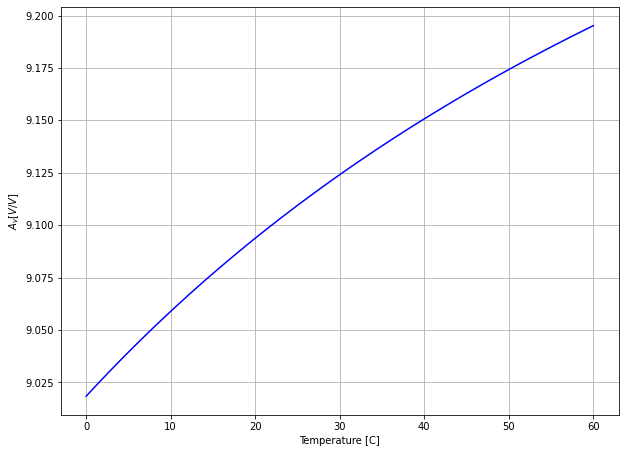

In [7]:
temp, reals, imags = read_ltspice_ac('Av_vs_temp_degen.csv')
gain = np.sqrt(np.asarray(reals)**2 + np.asarray(imags)**2)
plot_xy(temp, gain, 'Temperature [C]','$A_v [V/V]$')

 - The use of negative feedback has reduced the gain variation to about 2%!
 - The tradeoff is that the gain is much lower than without $R_E$
 - As we will see this is typical of negative feedback systems, which employ large *open-loop* gain to achieve a more precise (but lower) *closed-loop* gain

## Input bias network

<center><img src="img/CE_degen_bias.png" width=600 /></center>

$$ V_{B0} = \dfrac{R_{B2}}{R_{B2}+R_{B1}}\cdot V_{CC} $$

$$ R_{bias} = R_{B1}||R_{B2} $$

$$ f_{3dB,HP} = \dfrac{1}{2 \pi (R_{bias}||r_{in}) C_{AC}}$$

 - To employ a DC bias for the common-emitter amplifier, we can use a resistor divider combined with AC coupling for the signal
 - Note that the use of AC coupling prevents the passage of DC signals from input to output
 - The highpass corner frequency of the bias network depends on the bias resistor values, $C_{AC}$, and the input resistance of the amplifier
 - To minimize loading, the equivalent input resistance should be much larger than the source resistance $R_S$
 - The input resistance of the amplifier now comprises the parallel combination of $R_{B1}$, $R_{B2}$, and the resistance looking into the base of the transistor


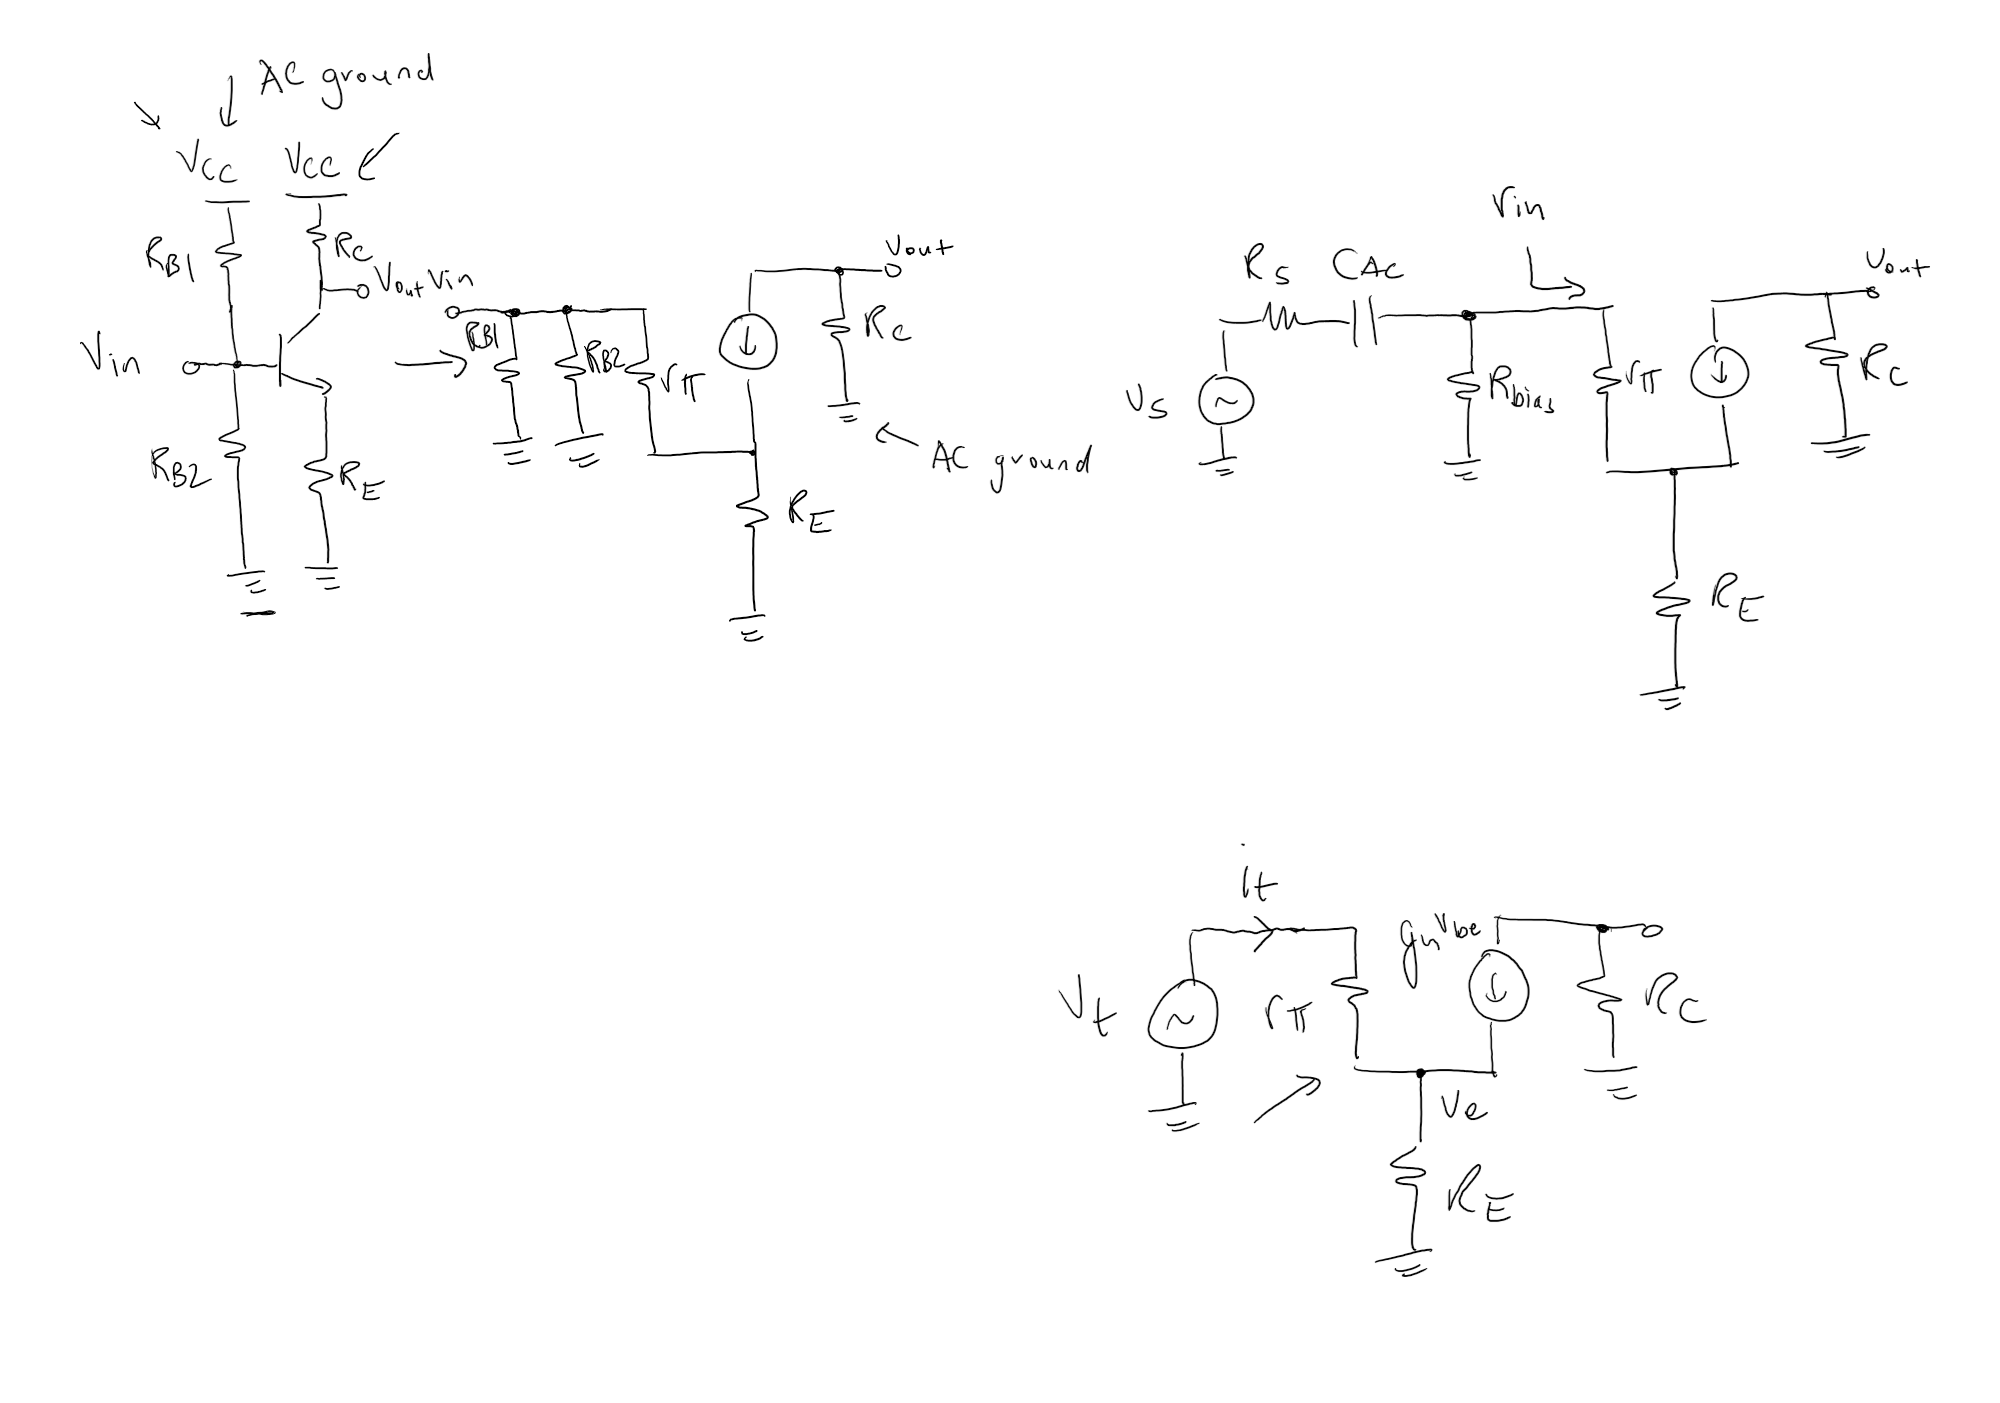

## Common-emitter output loading

<center><img src="img/CE_loading.png" width=450 /></center>

<br>

$$ \dfrac{v_{out}}{v_{in}} \approx -g_m\cdot R_C || R_L $$

$$ v_{out} = -g_mR_C \cdot \dfrac{R_L}{R_L + R_C} \cdot v_{in} $$

$$ R_L >> R_C $$

 - The high gain of the common-emitter amplifier makes it (and related structures) the typical means of achieving gain in operational amplifiers
 - However, $R_L$ should be much greater than $R_C$ to minimize loading and maintain the desired gain value
 - It is not always possible to guarantee the input resistance of the following stage will be large enough (e.g. when driving a speaker, the effect resistance is less than 100 $\Omega$)
 - We need some means of "buffering" the output resistance of the gain stage from the low input resistance of other circuit blocks

## Emitter follower

<center><img src="img/emitter_follower.png" width=400 /></center>

 - To estimate the DC operating point, we can assume a constant $V_{BE}$ (say, 600mV):
 
 $$ I_{C0} = \dfrac{V_{E}}{R_E} = \dfrac{V_B - V_{BE}}{R_E} = \dfrac{V_B - 0.6V}{R_E}$$
 
 - As with the degenerated emitter-follower, $v_e$ follows $v_{in}$, such that
 
 $$ v_{out} \approx v_{in} $$
 
    hence the name, "emitter-follower"

 - The *emitter-follower* does not provide gain (that is, the gain is ideally 1), but provides a high input impedance and low output impedance
 - This makes the emitter-follower well-suited for buffering gain stages against circuits with low input impedance
 - Note that the DC level of $V_{out}$ is approximately $600mV$ lower than that of $V_{in}$

## Emitter follower output resistance

<center><img src="img/EF_output_resistance.png" width=400 /></center>

$$ i_t = v_t \left(g_m  + \frac{1}{R_E}+ \frac{1}{r_\pi} \right)$$

$$ r_{out} = \dfrac{v_t}{i_t} = \dfrac{1}{g_m}||R_E|| r_{\pi} $$

$$  \dfrac{1}{g_m} << R_E, r_{\pi} $$ 

$$\rightarrow \boxed{r_{out} \approx \dfrac{1}{g_m}} $$

 - "Looking into" the output of the emitter-follower, we see an effective resistance of $\dfrac{1}{g_m}$
 - The output resistance of the emitter-follower can be controlled (reduced) by increasing the bias current, which lowers the transconductance $g_m$
 - Due to its low output resistance, the emitter-follower is typically used as an output stage for operational amplifiers 

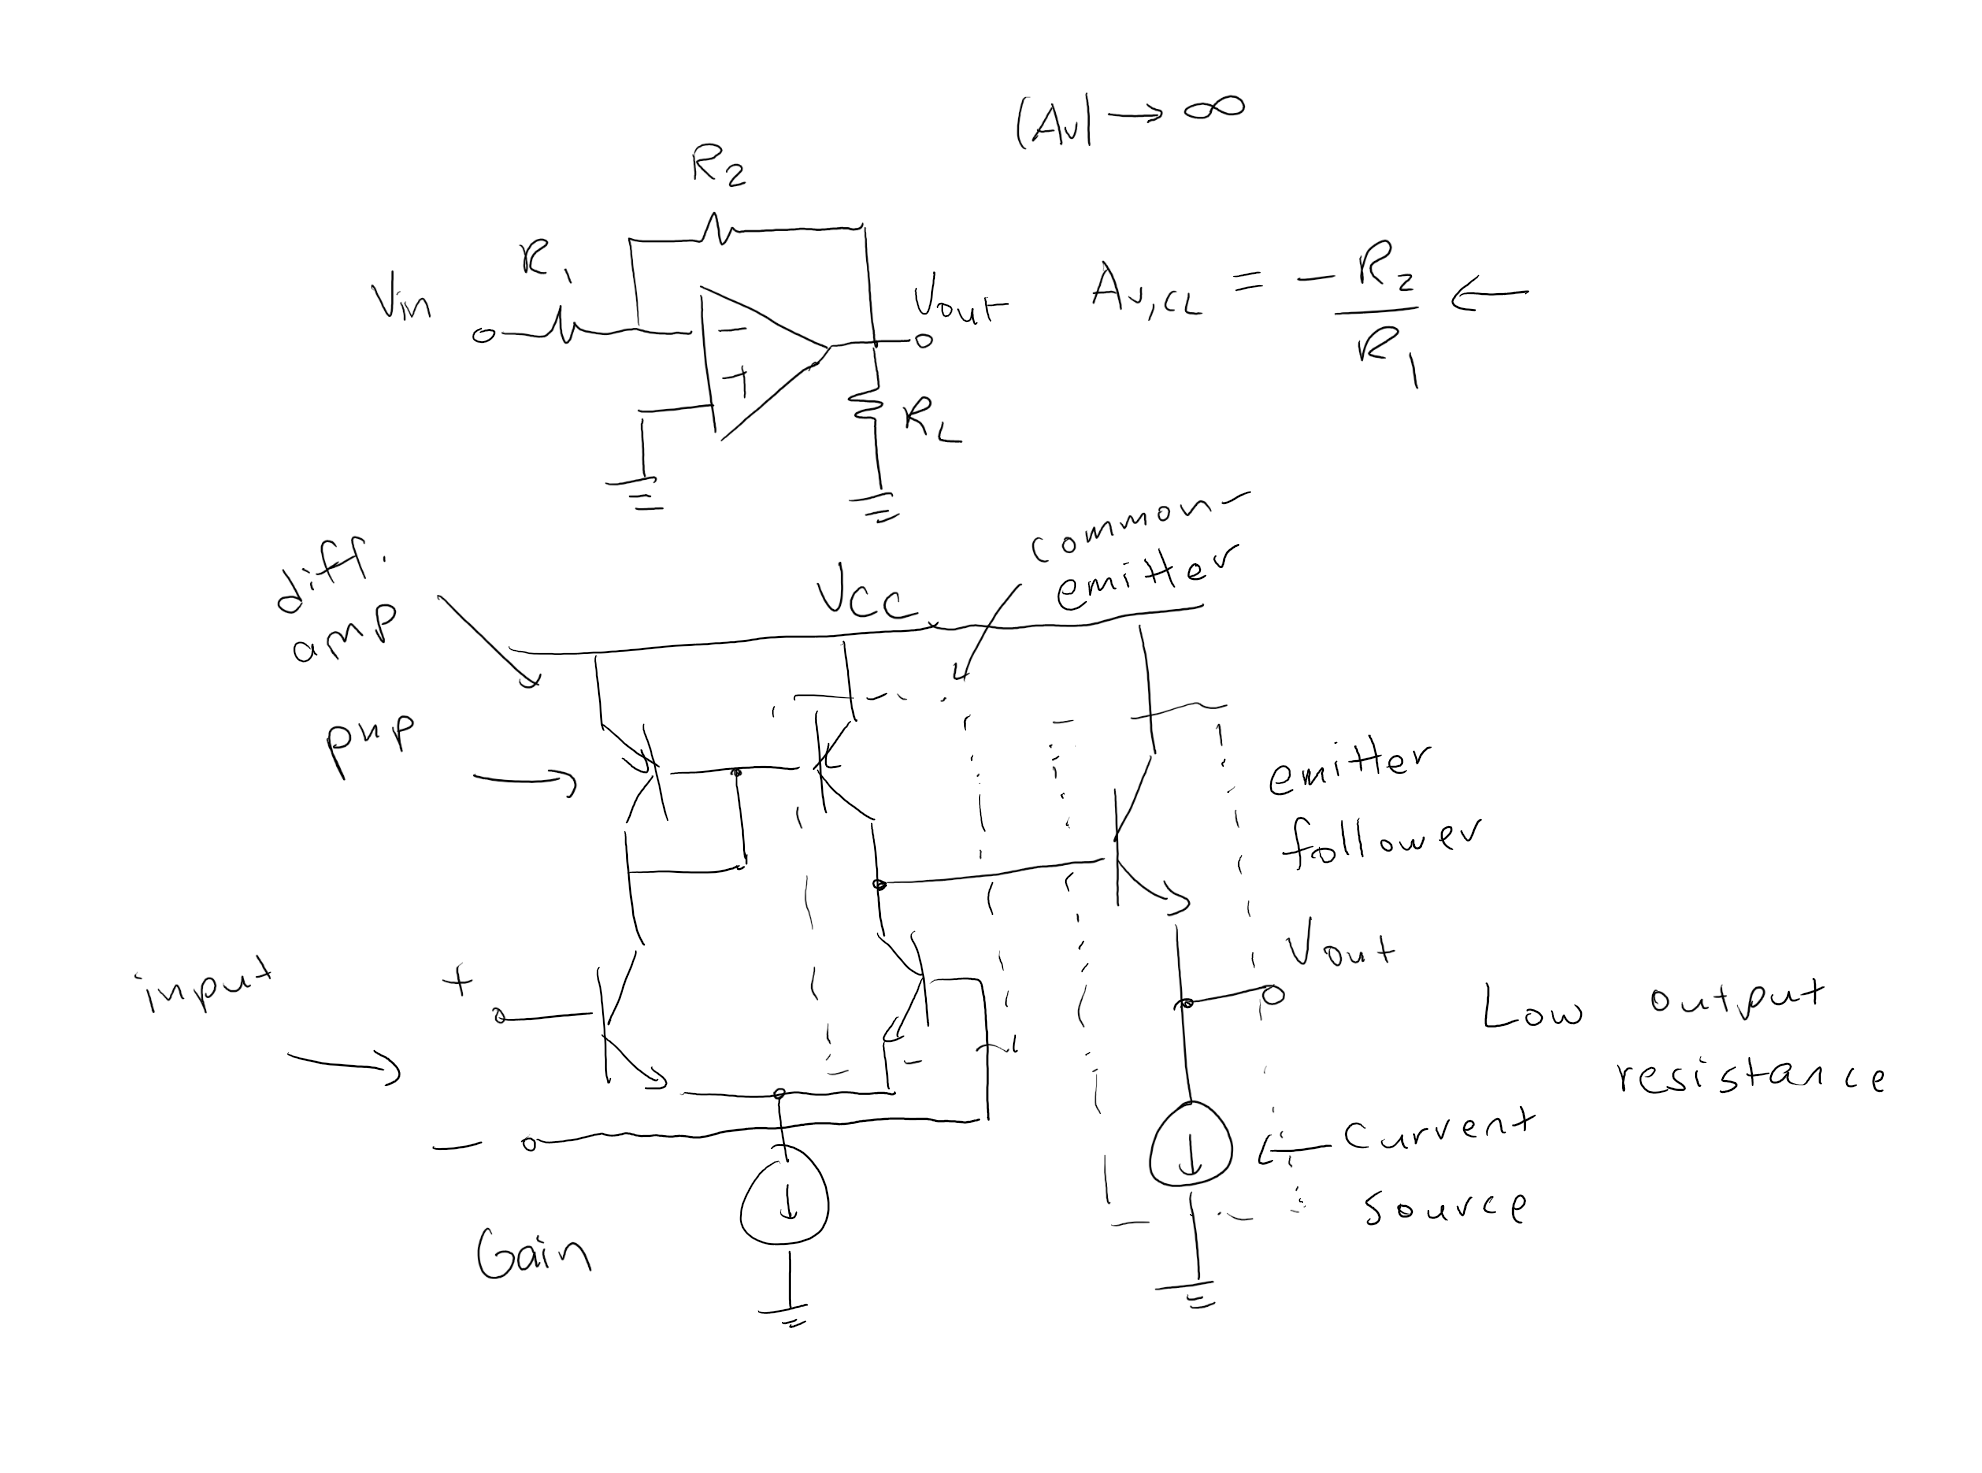

# Lecture 3 - Field effect transistors

## MOS transistor

<center><img src="img/mos_structure.png" width=500 /></center>

<center><img src="img/NMOS_symbol.png" width=250 /></center>

$$ I_d = f(V_{gs}, V_{ds}) $$

 - MOSFET: __M__etal-__O__xide-__S__emiconductor __F__ield __E__ffect __T__ransistor
 - $n$-type transistors (NMOS) consist of $p$-doped bulk, $n$-doped source/drain, polysilicon gate, and $SiO_2$ insulating layer
 - For NMOS transistors, drain current $I_d$ is controlled by the gate-source voltage $V_{gs}$, similar to the $V_{be}-I_c$ relationship in an $npn$ BJT
 - The influence of $V_{ds}$ on $I_d$ is a "second-order" effect, similar to the Early effect in BJTs

## Current flow in an NMOS transistor

<center><img src="img/NMOS_cross_section.png" width=600 /></center>

 - Inversion layer forms as minority carriers (electrons) are drawn from the $p$-type substrate to interface due to the *vertical* electric field formed by $V_{gs}$
 - Threshold voltage ($V_{th}$) defined as the $V_{gs}$ value at which the minority carrier (electrons) concentration equals that of the majority carriers (holes)
 - Electrons move from source to drain in the presence of a *lateral* electric field formed by $V_{ds}$

## Square-law MOSFET model

<center><img src="img/MOS_transistor.png" width=300 /></center>

$$I_d = \frac{1}{2}\mu C_{ox} \frac{W}{L}\left(V_{gs} - V_{th} \right)^2 $$

\begin{align} I_g = 0 && I_s = I_d
\end{align}

$$ V_{gs} = V_{th} + \sqrt{\frac{2\cdot I_d}{\mu C_{ox} \left(\frac{W}{L}\right)}}$$

 - If $V_{gs} > V_{th}$ and $V_{ds} > V_{gs} - V_{th}$, the transistor is said to be in *saturation* (mode used for analog design) 
 - In saturation, drain current ($I_c$) is a *quadratic* function of $V_{gs}$
 - At DC, gate current $I_g$ is effectively zero (extremely high input impedance)
 - If $I_d$ is held constant, $V_{gs}$ has a square-root dependence on $I_d$

## MOSFET I-V relationship

 - Let's define a function that uses the square-law model to calculate $I_d$ for an arbitrary $V_{gs}$:

In [2]:
def nmos_iv(V_gs, W, L):
    u_n = 350                 # electron mobility (device parameter)
    e_ox = 3.9*8.854e-12/100; # relative permittivity
    t_ox = 9e-9*100;          # oxide thickness
    C_ox = e_ox/t_ox          # oxide capacitance
    V_th = 0.7                # threshold voltage (device parameter)
    
    I_d = 0.5*u_n*C_ox*(W/L)*(V_gs - V_th)**2 

    return I_d

In [9]:
nmos_iv(0.9, 100, 1)

0.0002685713333333335

 - Let's plot $I_d$ versus $V_{gs}$

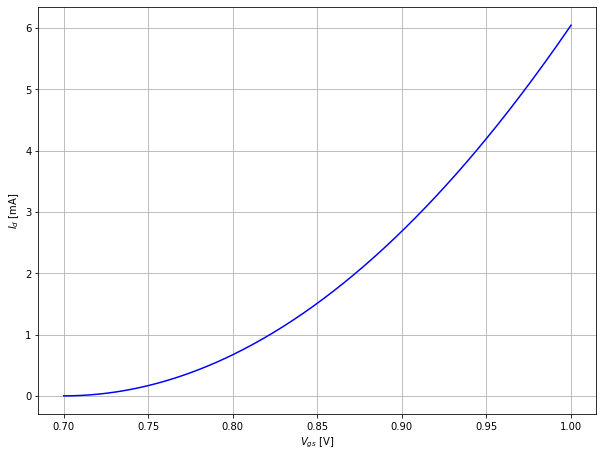

In [9]:
V_gs = np.linspace(0.7,1,num=300)
I_d = nmos_iv(V_gs, 1000, 1)
plot_xy(V_gs, 1e3*I_d, '$V_{gs}$ [V]', '$I_d$ [mA]') 

 - The $I_d$ versus $V_{gs}$ curve is less steep than the $I_c$ versus $V_{be}$ for the BJT (quadratic versus exponential)
 - This results in a *lower value of $g_m$ for a given DC current*

## Small-signal transconductance

 - As with with the BJT, we can calculate the transconductance $g_m$ using the derivative of $I_d$ with respect to $V_{gs}$:
 
 \begin{align}
 g_m = \dfrac{\partial}{\partial V_{gs}} \left[ \frac{1}{2}\mu C_{ox} \frac{W}{L}\left(V_{gs} - V_{th} \right)^2  \right]  = \mu C_{ox} \frac{W}{L}\left(V_{gs} - V_{th} \right)
 \end{align}
 
 - Similar to the BJT, $g_m$ depends linearly on the DC drain current for a constant value of $V_{gs} - V_{th}$:
 
 \begin{align}
 g_m = \mu C_{ox} \frac{W}{L}\left(V_{gs} - V_{th} \right) = \dfrac{2\cdot I_d}{V_{gs} - V_{th}}
 \end{align}
 
 - The quantity $V_{gs} - V_{th}$, often referred to as the *overdrive voltage*, can be controlled by  adjusting $W$ and $L$ for a given current (i.e. by controlling current density), typical values are > 300mV

## Transconductance versus square law

In [10]:
def g_m(V_GS0, W, L):
    V_th = 0.7                # threshold voltage (device parameter)
    I_D0 = nmos_iv(V_GS0, W, L)
    
    return 2*I_D0/(V_GS0 - V_th)

def gm_line (V_gs, W, L, V_GS0, I_D0):
    return g_m(V_GS0, W, L)*(V_gs - V_GS0) + I_D0

def plot_gm(V_gs, W, L, V_GS1, V_gs_range):
    fig, ax = plt.subplots(figsize=(10.0,7.5))
    ax.plot(V_gs, 1e3*nmos_iv(V_gs, W, L), 
            label=r'$\frac{1}{2}\mu C_{ox}\frac{W}{L}(V_{gs}-V_{th})^2$')
    I_D1 = nmos_iv(V_GS1, W, L)
    ax.scatter(V_GS1, 1e3*I_D1, color='C1',s=10)
    ax.plot(V_gs_range, 1e3*gm_line(V_gs_range, W, L, V_GS1, I_D1), 
            'C1--', linewidth=2, label=r'$g_mV_{gs}$')
    ax.set_xlabel(r'$V_{gs} [V]$')
    ax.set_ylabel(r'$I_{D} [mA]$')
    ax.grid()
    ax.legend()

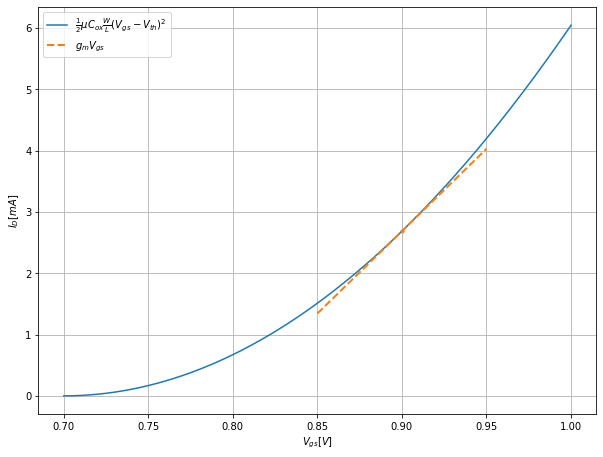

In [11]:
V_gs = np.linspace(0.7,1,num=300)
V_GS1 = 0.9
V_gs_range = np.linspace(V_GS1-0.05, V_GS1+0.05, 10)
plot_gm(V_gs, 1000, 1, V_GS1, V_gs_range)

## Channel-length modulation

<center><img src="img/channel_length_modulation.png" width=700 /></center>

 - Current flow in a MOSFET results is due to the lateral electric field applied over a distance $L$, a device parameter
 - As with the BJT, the MOSFET drain current exhibits a small dependence on $V_{ds}$, partially due to the modulation of channel length ($\Delta L$) as a function of the electric field near the drain implant region
 - This dependence is captured by a linear parameter $\lambda$, typically called the "channel-length modulation coefficient"
 - The resulting drain current expression becomes
 
 $$I_d = \frac{1}{2}\mu C_{ox} \frac{W}{L}\left(V_{gs} - V_{th} \right)^2\cdot (1+\lambda V_{ds}) $$

## Finite output resistance

 - The MOSFET drain current exhibits a *linear* dependence on $V_{ds}$ for $V_{ds} > V_{gs} - V_{th}$

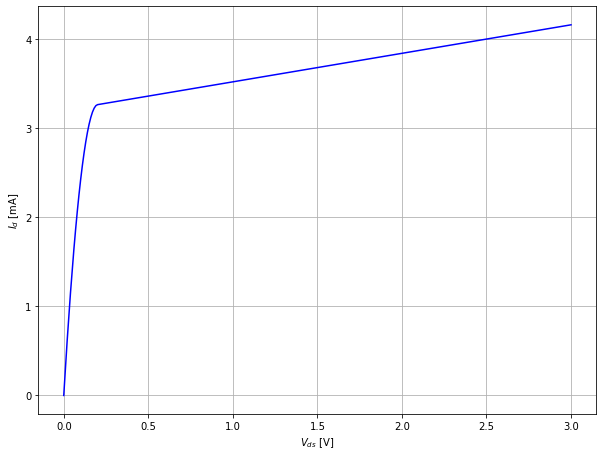

In [19]:
import pandas as pd
I_d = pd.read_csv('Id_Vds.csv', sep='\t')
plot_xy(I_d['v1'], 1e3*I_d['Id(M1)'], '$V_{ds}$ [V]', '$I_d$ [mA]')

 - For $V_{ds} < V_{gs} - V_{th}$, the MOSFET is said to be in *triode*, the region of operation used when the MOSFET operates a switch

## MOS small-signal model (DC)

<center><img src="img/MOS_small_signal_model.png" width=500 /></center>

$$ g_m = \dfrac{2\cdot I_{D0}}{V_{GS0}-V_{th}} $$

$$r_o = \dfrac{1}{\lambda I_{D0}}$$

 - The DC small-signal model of the MOSFET consists of the transconductance $g_m$ and output resistance $r_o$
 - This is analogous to the BJT small-signal model, but with *infinite input resistance at DC*
 - The product $g_m r_o$ is referred to as the *intrinsic gain* of the transistor, and represents the voltage gain with no external load resistance 
 - Intrinsic gain is a fundamental device property that determines how effective it is as a gain device

## Common-source amplifier

<center><img src="img/common_source.png" width=300 /></center>

<center><img src="img/CS_small_signal.png" width=400 /></center>

$$A_v = \frac{v_{out}}{v_{in}} = -g_m\cdot (R_D || r_o) $$

 - Like the common-emitter for the BJT, the common-source amplifier is considered a "high-gain" structure
 - The high input impedance of the FET makes the common-source structure useful for high-impedance sensors
 - At higher frequencies, the MOSFET oxide capacitance lowers the input impedance and limits its high-frequency performance
 - The maximum frequency at which a device can act as a gain element is called the *transit frequency*, often denoted by $f_t$

## BJTs versus FETs


 BJTs 
 - Advantages:
     - Low noise, high accuracy (e.g. $g_m$), and power efficiency
 - Disadvantanges
     - Low input impedance, non-zero base current
 - Primary applications:
     - Low-noise amplifiers, power amplifiers, opamps
 

FETs

 - Advantages:
     - Low power (digital), high impedance, great switches
 - Disadvantages:
     - Noisy, lots of variability, many non-ideal effects
 - Primary applications:
     - Digital circuits (CMOS), power switches, opamps (JFETs)